In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# generate the Hamiltonian of a 10-site Ising chain with periodic boundary conditions.

from qiskit.transpiler import CouplingMap
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
)
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit
from qiskit_addon_aqc_tensor.simulation import compute_overlap
from qiskit_addon_aqc_tensor.objective import MaximizeStateFidelity
from qiskit_aer import AerSimulator
from scipy.optimize import OptimizeResult, minimize
 
 
# Generate some coupling map to use for this example
coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)
 
# Choose a 10-qubit circle on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 4, 15, 3, 9]
)
 
# Get a qubit operator describing the Ising field model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)

hamiltonian

SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZZII', 'IIIIZZIIII', 'IIZZIIIIII', 'ZZIIIIIIII', 'ZIIIIIIIIZ', 'IIIIIIIZZI', 'IIIIIZZIII', 'IIIZZIIIII', 'IZZIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 1. +0.j, 1. +0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j,
 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j])

Split the time evolution into two pieces for classical and quantum execution

In [3]:
# Generate circuit to be compressed
aqc_evolution_time = 4.0
aqc_target_num_trotter_steps = 45
 
aqc_target_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_target_num_trotter_steps),
    time=aqc_evolution_time,
)
 
# Generate circuit to execute on hardware
subsequent_evolution_time = 1.0
subsequent_num_trotter_steps = 5
 
subsequent_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=subsequent_num_trotter_steps),
    time=subsequent_evolution_time,
)

In [12]:
# Comparison circuit
aqc_comparison_num_trotter_steps = int(
    subsequent_num_trotter_steps
    / subsequent_evolution_time
    * aqc_evolution_time
)
print(aqc_comparison_num_trotter_steps)
 
comparison_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_comparison_num_trotter_steps),
    time=aqc_evolution_time,
)

20


Generate ansatz and construct MPS simulation

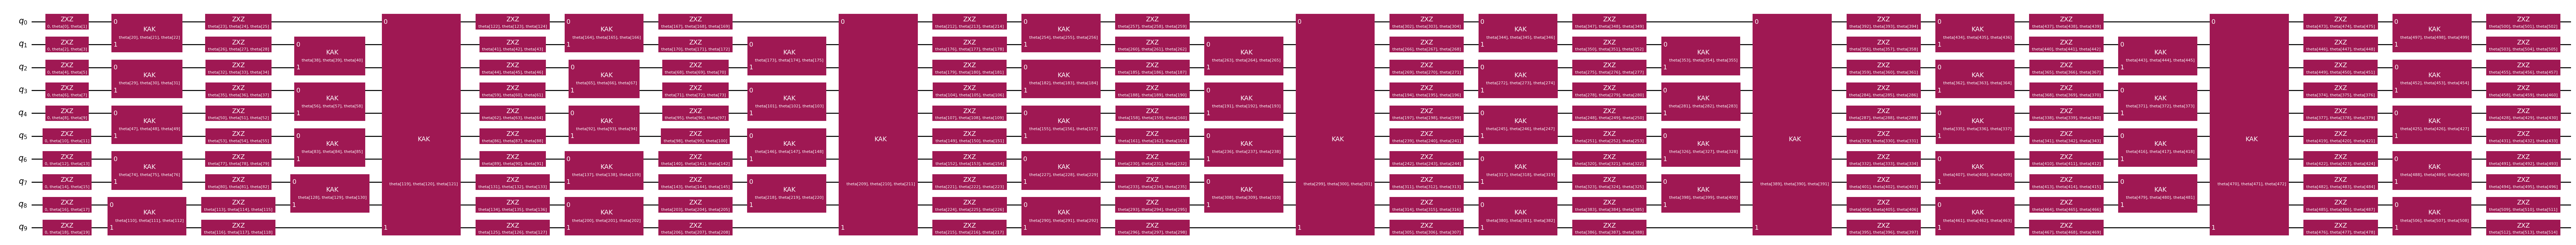

In [5]:
aqc_ansatz_num_trotter_steps = 5
 
aqc_good_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=aqc_ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)
 
aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    aqc_good_circuit, qubits_initially_zero=True
)
aqc_ansatz.draw("mpl", fold=-1)

In [6]:
# Generate MPS simulator settings and obtain the MPS representation of the target state
simulator_settings = AerSimulator(
    method="matrix_product_state",
    matrix_product_state_max_bond_dimension=100,
)
aqc_target_mps = tensornetwork_from_circuit(
    aqc_target_circuit, simulator_settings
)
 
 
# Compute the fidelity between the MPS representation of the target state and the state produced by the comparison circuit
comparison_mps = tensornetwork_from_circuit(
    comparison_circuit, simulator_settings
)
comparison_fidelity = (
    abs(compute_overlap(comparison_mps, aqc_target_mps)) ** 2
)
print(f"Comparison fidelity: {comparison_fidelity}")

Comparison fidelity: 0.9997111919736127


Optimize the parameters of the ansatz using the MPS

In [7]:
objective = MaximizeStateFidelity(
    aqc_target_mps, aqc_ansatz, simulator_settings
)
 
stopping_point = 1 - comparison_fidelity
 
 
def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration
 
 
result = minimize(
    objective,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if (
    result.status
    not in (
        0,
        1,
        99,
    )
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(
        f"Optimization failed: {result.message} (status={result.status})"
    )
 
print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Intermediate result: Fidelity 0.95084318
Intermediate result: Fidelity 0.9841008
Intermediate result: Fidelity 0.99142201
Intermediate result: Fidelity 0.9952143
Intermediate result: Fidelity 0.99566702
Intermediate result: Fidelity 0.99650041
Intermediate result: Fidelity 0.99683464
Intermediate result: Fidelity 0.99720409
Intermediate result: Fidelity 0.99761708
Intermediate result: Fidelity 0.9980905
Intermediate result: Fidelity 0.99838237
Intermediate result: Fidelity 0.99861828
Intermediate result: Fidelity 0.99874601
Intermediate result: Fidelity 0.99892684
Intermediate result: Fidelity 0.99908117
Intermediate result: Fidelity 0.9991773
Intermediate result: Fidelity 0.9992545
Intermediate result: Fidelity 0.99933141
Intermediate result: Fidelity 0.99947188
Intermediate result: Fidelity 0.9995638
Intermediate result: Fidelity 0.99964402
Intermediate result: Fidelity 0.99967355
Intermediate result: Fidelity 0.9996875
Intermediate result: Fidelity 0.99974616
Done after 24 iteration

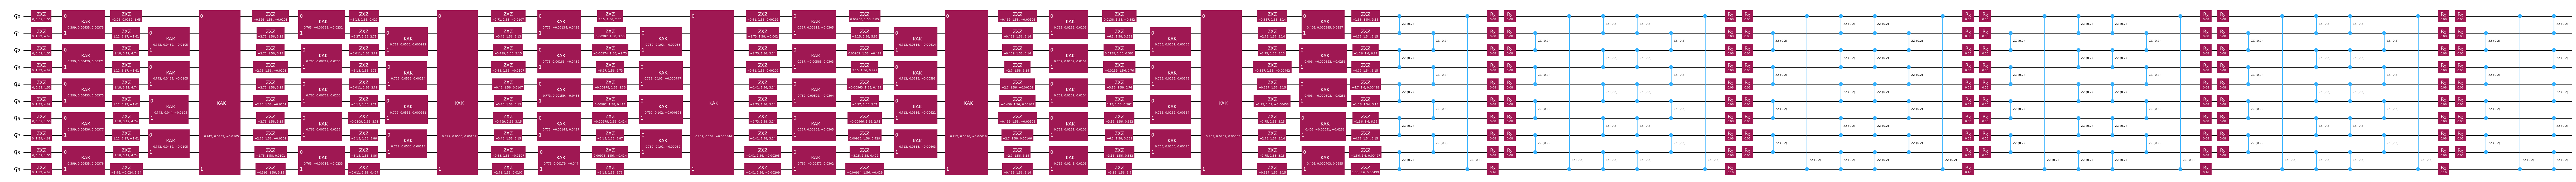

In [8]:
# full time evolution cirucit to be passed to a transpiler pipeline and executed on hardware
final_circuit = aqc_ansatz.assign_parameters(aqc_final_parameters)
final_circuit.compose(subsequent_circuit, inplace=True)
final_circuit.draw("mpl", fold=-1) 